In [1]:
# model implementation
from ml.models.nn import MLP
from ml.functions.loss import MeanSquareErrorLoss
from ml.algorithms.optimization import BackpropSGD
from ml.functions.activation import Sigmoid, Identity, Relu

# model selection
from ml.model_selection import GridSearchCV
from ml.functions.metrics.regression import RMSE, MAE, MRE

# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

# Utility
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(25)

## Q1 - Neural Net for regression

### Load dataset

In [2]:
X, y = load_csv('./datasets/concrete.csv')

#### Split into train (60%), validation (20%) and test (20%)

In [3]:
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.6, shuffle=True)
X_train, y_train, X_val, y_val = split_train_test(X_train, y_train, 0.75, shuffle=False)

### Scale data

In [4]:
# create min-max scalers
x_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

# scale train data
X_train_scaled = x_scaler.transform(X_train)
y_train_scaled = y_scaler.transform(y_train)

# scale test data
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

# scale validation data
X_val_scaled = x_scaler.transform(X_val)
y_val_scaled = y_scaler.transform(y_val)

### Find best hyperparameters (num neurons and activation function) using grid search

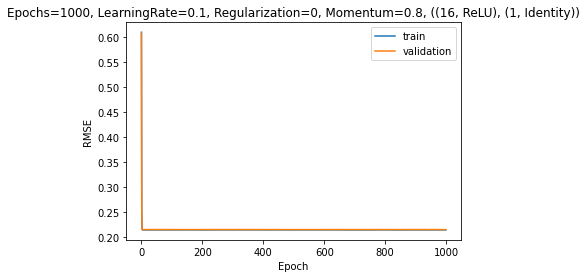

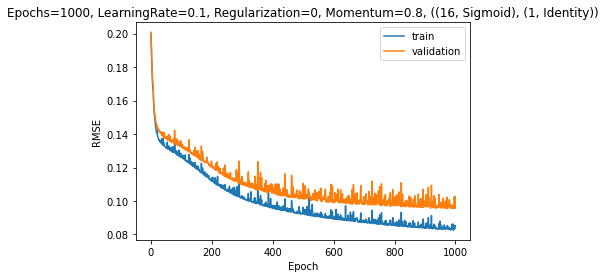

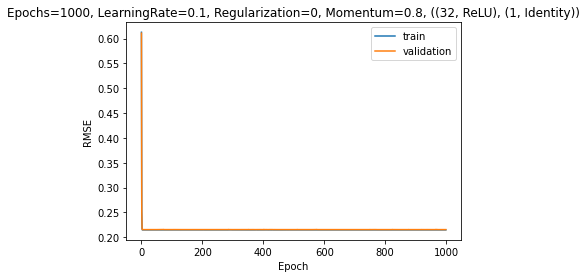

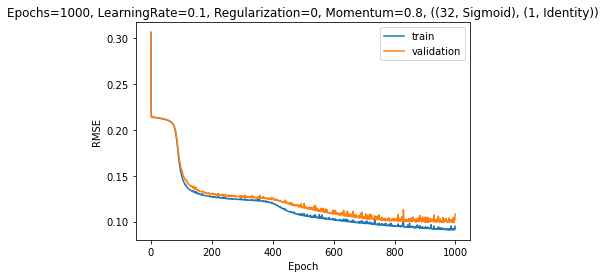

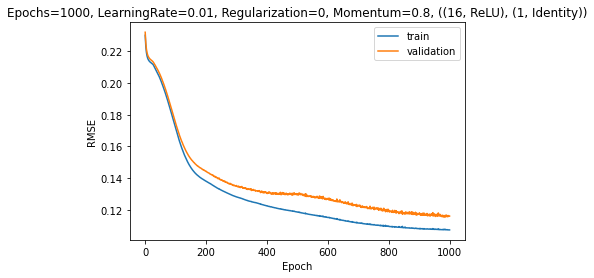

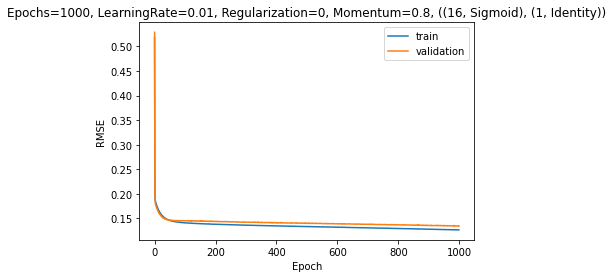

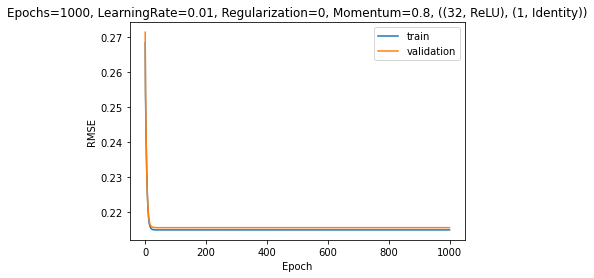

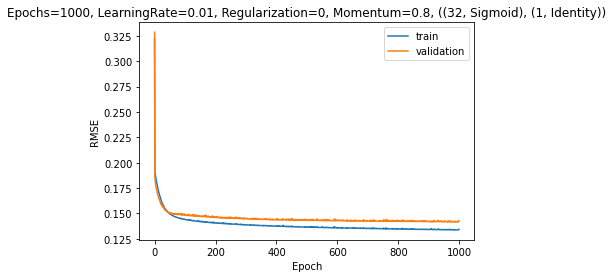

In [5]:
# fixed hyperparams
reg = 0
momentum=0.8

min_val_err = float("inf")

for lr in [0.1, 0.01]:
    for num_neurons in [16, 32]:
        for function in [Relu, Sigmoid]:
            solver = BackpropSGD(epochs=1000,
                        learning_rate=lr,     # <-- hyperparam under test
                        regularization=reg,
                        momentum=momentum,
                        batch_size=32,
                        metrics=RMSE())

            layers = (
                (num_neurons, function()),     # <-- hyperparams under test
                (1, Identity()),
            )

            mlp = MLP(layers=layers, solver=solver, loss=MeanSquareErrorLoss)
            train_err, val_err = mlp.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)

            plt.plot(train_err, label="train")
            plt.plot(val_err, label="validation")
            plt.legend()
            plt.title(f"{solver}, {layers}")
            plt.ylabel("RMSE")
            plt.xlabel("Epoch")
            plt.show()

            if val_err[-1] < min_val_err:
                best_model = mlp
                min_val_err = val_err[-1]

### Hyperparameters of the best MLP

In [6]:
print("Best hyperparameters for MLP:", best_model.solver, "Layers:", best_model.layers)

Best hyperparameters for MLP: Epochs=1000, LearningRate=0.1, Regularization=0, Momentum=0.8 Layers: ((16, Sigmoid), (1, Identity))


### Train MLP with best hyperparameters

In [7]:
mlp = MLP(layers = best_model.layers, solver=best_model.solver, loss=MeanSquareErrorLoss)
train_err, test_err = mlp.fit(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

### Report train and test errors during training

Text(0.5, 0, 'Epoch')

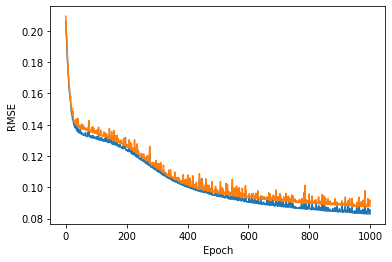

In [8]:
plt.plot(train_err)
plt.plot(test_err)

plt.ylabel("RMSE")
plt.xlabel("Epoch")

### Report train and test RMSE, MAE and MRE

In [9]:
y_train_pred_scaled = mlp.predict(X_train_scaled)
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)

y_test_pred_scaled = mlp.predict(X_test_scaled)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)

y_val_pred_scaled = mlp.predict(X_val_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)

rmse = RMSE()
mae = MAE()

print("--\nRMSE(train):", rmse.measure(y_train, y_train_pred), "\nRMSE (test): ", rmse.measure(y_test, y_test_pred), "\nRMSE (val): ", rmse.measure(y_val, y_val_pred))
print("--\nMAE(train):",   mae.measure(y_train, y_train_pred), "\nMAE (test): ",   mae.measure(y_test, y_test_pred), "\nMAE (val): ", mae.measure(y_val, y_val_pred))

--
RMSE(train): 6.401318289609681 
RMSE (test):  6.790452710099015 
RMSE (val):  7.463987934789873
--
MAE(train): 4.858613292055287 
MAE (test):  5.221022087219081 
MAE (val):  5.586208879059095
